<h1>Trabalho 3 - Classificação</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import path
import cv2
import scipy.misc

In [2]:
dados = np.loadtxt('ocr_car_numbers_rotulado.txt')

<h4>Funções auxiliares:</h4>

In [3]:
def getImage(data, row):
    image = data[row, :-1] #seleciona a lilha e apaga o útima coluna
    image.shape = (35, 35) #converte para duas dimensões
    image[image==1]=255
    image = np.uint8(image)
    return image

def getChainCode(x1, y1, x2, y2): 
    dx = x2 - x1 
    dy = y2 - y1 
    
    if dx>0: #Significa que as posições podem ser (5,4,3)
        if dy <0 :
            code = 5
        elif dy==0:
            code = 4
        else:
            code = 3

    elif dx==0: # Significa que as posicoes podem ser (6,2)
        if dy<0:
            code = 6
        elif dy>0:
            code = 2
        else:
            code=8
    else: #Significa que as posicoes podem ser (7,0,1)
        if dy<0:
            code = 7
        elif dy==0:
            code = 0
        else:
            code = 1

    return code 

def generateChainCode(ListOfPoints): 
    chainCode = [] 
    textChain = " "
    for i in range(len(ListOfPoints)):
        a = ListOfPoints[i][0]
        #print("valor de A = ",a[0],a[1]) 
        if i != len(ListOfPoints)-1:
            b = ListOfPoints[i + 1][0]
            #print("valor de B = ",b[0],b[1])
        else :
            b = ListOfPoints[0][0] 
        chainCode.append(getChainCode(a[0], a[1], b[0], b[1]))
        textChain = textChain + str(getChainCode(a[0], a[1], b[0], b[1]))
        textChainT = str(getChainCode(a[0], a[1], b[0], b[1]))
        
    return chainCode,textChain 

def normalizar(signal, smaller):
    
    index = 0
    newSignal = []
    prop = len(signal)/smaller
    d = prop
    
    while len(newSignal) < smaller:
        
        newSignal.append(signal[index])
        i, d = divmod(d, 1) #separa a pater inteira da parte decimal
        index += int(i) #adiciona a parte inteira ao indice
        d += prop #adiciona ao resto a proporcao        
        
    return newSignal

def centroid(img):
    ret,thresh = cv2.threshold(img,200,255,cv2.THRESH_BINARY)
    height, width = thresh.shape[:2]

    mass = 0
    Xcm  = 0.0
    Ycm  = 0.0

    for i in range(width) :
        for j in range(height) :
            if not thresh[j][i] :
                mass += 1
                Xcm  += i
                Ycm  += j

    return  [Ycm/mass, Xcm/mass]

def signature(image):
    sign = []
    contours, _ = cv2.findContours(image,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    center = centroid(image)
    for i in range(len(contours[0])):
        point = contours[0][i][0]
        dist = np.linalg.norm(point-center)
        sign.append(dist)
    
    return sign


In [4]:
#extraindo as imagens da fonte de dados
imgs = [getImage(dados, i) for i in range(len(dados))]

#array de bordas
kernel = np.ones((3,3), np.uint8)
edges = [cv2.dilate(img, kernel, iterations=1) - img for img in imgs]

In [5]:
#retirando as coordenadas do array de bordas 
n_contours = []

for i in range(len(edges)):
    contours, hierarchy = cv2.findContours(edges[i],cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    n_contours.append(contours)


In [6]:
#montando o dataset do codigo da cadeia
chainCodes = []

for contours in n_contours:
    chainCode,tsx = generateChainCode(contours[0])
    chainCodes.append(chainCode)
    
smaller = min([len(chainCode) for chainCode in chainCodes]) #pega o comprimento da menor cadeia
chainCodes = [normalizar(chainCode, smaller) for chainCode in chainCodes] #faz a normalização das cadeias

chainCodes = np.array(chainCodes)

In [7]:
#montando o dataset das assinaturas
signatures = [signature(img) for img in imgs]

smaller = min([len(signature) for signature in signatures]) #pega o comprimento da menor cadeia
signatures = [normalizar(signature, smaller) for signature in signatures] #faz a normalização das cadeias

signatures = np.array(signatures)

<h2>Classificador 1 - SVM (MÁQUINA DE VETORES DE SUPORTE)</h2>
<h3>Classificador SVM com o dataset chainCodes<h/3>

In [8]:
from sklearn.model_selection import train_test_split

X = chainCodes
y = dados[:,-1]

# Separando os dados de treino e teste:
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=30)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Pipeline:
steps = [('scaler', StandardScaler()), ('SVM', SVC(kernel='poly'))]
pipeline = Pipeline(steps)

# Utilizando o GridSearchCV para o ajuste dos parâmetros:
parameters = {'SVM__C':[0.001, 0.1, 100, 10e5], 'SVM__gamma':[10,1,0.1,0.01]}
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)

# Treinando o modelo:
grid.fit(X_train, y_train)
print ("score = %3.2f" %(grid.score(X_test, y_test)))
print ("best parameters from train data: ", grid.best_params_)

score = 0.99
best parameters from train data:  {'SVM__C': 0.001, 'SVM__gamma': 1}


In [10]:
# Instanciando o algoritmo e passando os melhores parâmetros:
svc = SVC(C=0.001,gamma=1,kernel='poly')

In [11]:
# Treinando o modelo:
svc.fit(X_train,y_train)

# Realizando as predições:
resultado = svc.predict(X_test)

# Métricas de classificação:
from sklearn import metrics
print(metrics.classification_report(y_test,resultado))

              precision    recall  f1-score   support

         0.0       0.89      0.92      0.90        59
         1.0       0.99      1.00      0.99        81
         2.0       1.00      1.00      1.00        54
         3.0       1.00      0.99      0.99        74
         4.0       1.00      0.99      0.99        82
         5.0       1.00      1.00      1.00        73
         6.0       1.00      1.00      1.00        79
         7.0       1.00      1.00      1.00        59
         8.0       0.91      0.89      0.90        56
         9.0       1.00      1.00      1.00        54

    accuracy                           0.98       671
   macro avg       0.98      0.98      0.98       671
weighted avg       0.98      0.98      0.98       671



In [12]:
# Matriz de confusão:
print (pd.crosstab(y_test,resultado, rownames=['Real'], colnames=['Predito'], margins=True))

Predito  0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  All
Real                                                          
0.0       54    0    0    0    0    0    0    0    5    0   59
1.0        0   81    0    0    0    0    0    0    0    0   81
2.0        0    0   54    0    0    0    0    0    0    0   54
3.0        0    1    0   73    0    0    0    0    0    0   74
4.0        1    0    0    0   81    0    0    0    0    0   82
5.0        0    0    0    0    0   73    0    0    0    0   73
6.0        0    0    0    0    0    0   79    0    0    0   79
7.0        0    0    0    0    0    0    0   59    0    0   59
8.0        6    0    0    0    0    0    0    0   50    0   56
9.0        0    0    0    0    0    0    0    0    0   54   54
All       61   82   54   73   81   73   79   59   55   54  671


<h3>Classificador SVM com o dataset signatures<h/3>

In [13]:
X = signatures
y = dados[:,-1]

# Separando os dados de treino e teste:
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=30)

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Pipeline:
steps = [('scaler', StandardScaler()), ('SVM', SVC(kernel='poly'))]
pipeline = Pipeline(steps)

# Utilizando o GridSearchCV para o ajuste dos parâmetros:
parameters = {'SVM__C':[0.001, 0.1, 100, 10e5], 'SVM__gamma':[10,1,0.1,0.01]}
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)

# Treinando o modelo:
grid.fit(X_train, y_train)
print ("score = %3.2f" %(grid.score(X_test, y_test)))
print ("best parameters from train data: ", grid.best_params_)

score = 1.00
best parameters from train data:  {'SVM__C': 0.1, 'SVM__gamma': 0.1}


In [15]:
# Instanciando o algoritmo e passando os melhores parâmetros:
svc = SVC(C=0.1,gamma=0.1,kernel='poly')

# Treinando o modelo:
svc.fit(X_train,y_train)

# Realizando as predições:
resultado = svc.predict(X_test)

# Métricas de classificação:
from sklearn import metrics
print(metrics.classification_report(y_test,resultado))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        59
         1.0       0.99      1.00      0.99        81
         2.0       1.00      1.00      1.00        54
         3.0       1.00      0.99      0.99        74
         4.0       1.00      1.00      1.00        82
         5.0       1.00      1.00      1.00        73
         6.0       1.00      1.00      1.00        79
         7.0       1.00      1.00      1.00        59
         8.0       0.96      0.96      0.96        56
         9.0       1.00      1.00      1.00        54

    accuracy                           0.99       671
   macro avg       0.99      0.99      0.99       671
weighted avg       0.99      0.99      0.99       671



<h2>Classificador 2 - REDE NEURAL ARTIFICIAL (RNA)</h2>
<h4>Rede Neural com dataset do chainCodes</h4>
<p>Depois de carregado o dataset, e montado uma sequencia de camadas com a biblioteca Keras onde primeiro e definida a quantidade correta de inputs de entrada, no caso 67, utilizando o argumento input_dim. Foi utilizada seis camadas, as quais as quatro primeiras utilizarão a função de ativação ReLU e a função softmax na última.</p>

In [16]:
# importar os pacotes necessários
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import confusion_matrix

In [17]:
from sklearn.model_selection import train_test_split
X = chainCodes
Y = dados[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=84)

In [18]:
from keras.utils.np_utils import to_categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [19]:
model = Sequential()
model.add(Dense(784, input_dim=67, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) #Otimização do modelo


In [20]:
h = model.fit(X_train, y_train_cat, epochs=10, verbose=1, validation_split=0.1) #validation_data=(X_test, y_test_cat)

Epoch 1/10
76/76 [==============================] - 42s 31ms/step - loss: 1.0811 - accuracy: 0.6513 - val_loss: 0.2625 - val_accuracy: 0.8810
Epoch 2/10
76/76 [==============================] - 2s 22ms/step - loss: 0.3020 - accuracy: 0.8777 - val_loss: 0.1703 - val_accuracy: 0.8996
Epoch 3/10
76/76 [==============================] - 1s 16ms/step - loss: 0.2214 - accuracy: 0.8947 - val_loss: 0.1887 - val_accuracy: 0.8996
Epoch 4/10
76/76 [==============================] - 1s 16ms/step - loss: 0.1961 - accuracy: 0.9080 - val_loss: 0.1446 - val_accuracy: 0.9257
Epoch 5/10
76/76 [==============================] - 1s 16ms/step - loss: 0.2031 - accuracy: 0.8964 - val_loss: 0.2771 - val_accuracy: 0.8773
Epoch 6/10
76/76 [==============================] - 1s 19ms/step - loss: 0.1566 - accuracy: 0.9096 - val_loss: 0.1242 - val_accuracy: 0.9257
Epoch 7/10
76/76 [==============================] - 1s 17ms/step - loss: 0.2225 - accuracy: 0.9059 - val_loss: 0.1220 - val_accuracy: 0.9480
Epoch 8/10
7

In [24]:
results = model.evaluate(X_test, y_test_cat)
print('Train: ', results[1])

21/21 [==============================] - 0s 4ms/step - loss: 0.1623 - accuracy: 0.9136
Train:  0.9135618209838867


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 784)               53312     
                                                                 
 dense_1 (Dense)             (None, 512)               401920    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 623,914
Trainable params: 623,914
Non-trai

Text(0.5, 0, 'Epochs')

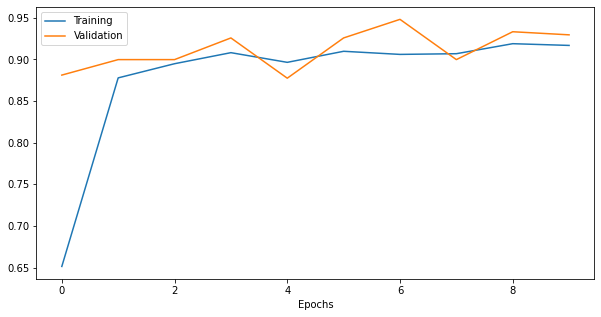

In [26]:
plt.figure(figsize=(10,5))
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.xlabel('Epochs')

<h4>Rede Neural com dataset Assinatura</h4>

In [27]:
X = signatures
Y = dados[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=84)

In [28]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [29]:
model = Sequential()
model.add(Dense(512, input_dim=59, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #Otimização do modelo

In [30]:
h = model.fit(X_train, y_train_cat, epochs=10, verbose=1, validation_split=0.1) #validation_data=(X_test, y_test_cat)

Epoch 1/10
71/71 [==============================] - 5s 13ms/step - loss: 1.3596 - accuracy: 0.6795 - val_loss: 0.3104 - val_accuracy: 0.8889
Epoch 2/10
71/71 [==============================] - 1s 8ms/step - loss: 0.2768 - accuracy: 0.8957 - val_loss: 0.1533 - val_accuracy: 0.9286
Epoch 3/10
71/71 [==============================] - 1s 9ms/step - loss: 0.2390 - accuracy: 0.9019 - val_loss: 0.1370 - val_accuracy: 0.9325
Epoch 4/10
71/71 [==============================] - 0s 7ms/step - loss: 0.1679 - accuracy: 0.9306 - val_loss: 0.1825 - val_accuracy: 0.9127
Epoch 5/10
71/71 [==============================] - 1s 8ms/step - loss: 0.1878 - accuracy: 0.9248 - val_loss: 0.1011 - val_accuracy: 0.9722
Epoch 6/10
71/71 [==============================] - 1s 9ms/step - loss: 0.1656 - accuracy: 0.9350 - val_loss: 0.1401 - val_accuracy: 0.8929
Epoch 7/10
71/71 [==============================] - 1s 8ms/step - loss: 0.1303 - accuracy: 0.9474 - val_loss: 0.1371 - val_accuracy: 0.9167
Epoch 8/10
71/71 [=

In [31]:
results = model.evaluate(X_test, y_test_cat)
print('Train: ', results[1])

27/27 [==============================] - 0s 3ms/step - loss: 0.1318 - accuracy: 0.9320
Train:  0.9319809079170227


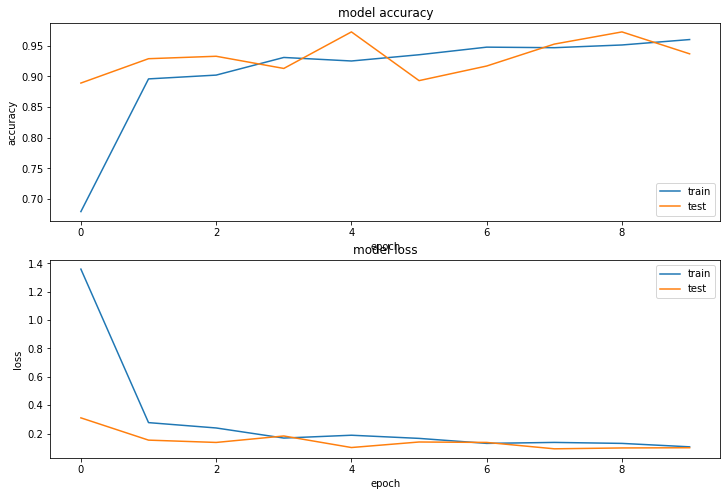

In [32]:
# plotting the metrics
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

<h4>Rede Neural com os valores originais</h4>

In [33]:
X = dados[:, :-1]
Y = dados[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=84)

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [34]:
model = Sequential()
model.add(Dense(784, input_dim=1225, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
h = model.fit(X_train, y_train_cat, epochs=10, verbose=1, validation_split=0.1) #validation_data=(X_test, y_test_cat)

Epoch 1/10
76/76 [==============================] - 3s 23ms/step - loss: 17.9899 - accuracy: 0.7181 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
76/76 [==============================] - 1s 20ms/step - loss: 1.0735 - accuracy: 0.9548 - val_loss: 2.6146e-08 - val_accuracy: 1.0000
Epoch 3/10
76/76 [==============================] - 2s 20ms/step - loss: 0.5017 - accuracy: 0.9772 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
76/76 [==============================] - 1s 20ms/step - loss: 0.6580 - accuracy: 0.9772 - val_loss: 3.1375e-07 - val_accuracy: 1.0000
Epoch 5/10
76/76 [==============================] - 1s 20ms/step - loss: 0.6557 - accuracy: 0.9714 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
76/76 [==============================] - 1s 20ms/step - loss: 0.3604 - accuracy: 0.9888 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
76/76 [==============================] - 1s 20ms/step - loss: 0.4619 - accuracy: 0.9847 - val_loss: 0.0014 - val_accur

In [36]:
results = model.evaluate(X_test, y_test_cat)
print('Train: ', results[1])

21/21 [==============================] - 0s 11ms/step - loss: 1.2725 - accuracy: 0.9970
Train:  0.997019350528717


Text(0.5, 0, 'Epochs')

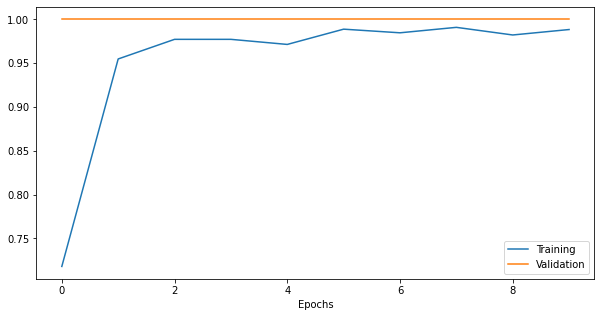

In [37]:
plt.figure(figsize=(10,5))
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.xlabel('Epochs')

<h2>Rede Neural Convolucional (CNN)</h2>
<p>CNN é um tipo de Rede Neural utilizado para classificar imagens</p>

In [38]:
# importar os pacotes necessários
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report

In [39]:
X = dados[:, :-1]
Y = dados[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=84)


In [40]:
=X_train.reshape(-1,35,35,1) #conjunto de treinamento
X_test=X_test.reshape(-1,35,35,1) #conjunto de teste

from keras.utils.np_utils import to_categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [101]:
model = Sequential()
model.add(Conv2D(16, (5,5), activation='relu', padding='same', input_shape=(35, 35,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (5,5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [102]:
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 35, 35, 16)        416       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 17, 17, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 17, 17, 32)        12832     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 8, 8, 32)          0         
                                                                 
 flatten_8 (Flatten)         (None, 2048)            

In [103]:
# reduz o parâmetro de learning rate se não houver 
# melhoras em determinado número de epocas
# útil para encontrar o mínimo global.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

history = model.fit(X_train,
                        y_train_cat,
                        batch_size = 32,
                        epochs = 10,
                        validation_split=0.2,
                        validation_data=(X_test, y_test_cat),
                        verbose = 1,
                        callbacks=[learning_rate_reduction])

Epoch 1/10
67/67 [==============================] - 6s 55ms/step - loss: 6.7370 - accuracy: 0.3288 - val_loss: 1.0292 - val_accuracy: 0.5996 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - 3s 49ms/step - loss: 1.2967 - accuracy: 0.5168 - val_loss: 0.6223 - val_accuracy: 0.7169 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - 3s 48ms/step - loss: 0.9560 - accuracy: 0.6012 - val_loss: 0.3884 - val_accuracy: 0.8678 - lr: 0.0010
Epoch 4/10
67/67 [==============================] - 3s 49ms/step - loss: 0.7085 - accuracy: 0.7062 - val_loss: 0.0865 - val_accuracy: 0.9981 - lr: 0.0010
Epoch 5/10
67/67 [==============================] - 3s 51ms/step - loss: 0.6376 - accuracy: 0.7295 - val_loss: 0.0640 - val_accuracy: 0.9981 - lr: 0.0010
Epoch 6/10
67/67 [==============================] - 3s 50ms/step - loss: 0.5589 - accuracy: 0.7631 - val_loss: 0.0238 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/10
67/67 [==============================] - 4s 54ms/step - loss: 0.4

In [104]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
range_epochs = range(1, len(acc) + 1)

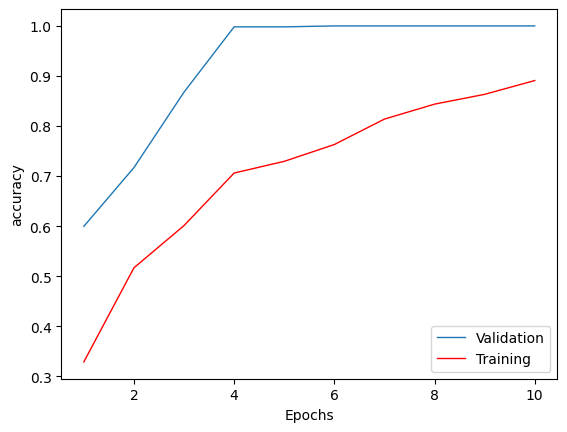

In [105]:
plt.style.use('default')
accuracy_val = plt.plot(range_epochs, val_acc, label='Validation')
accuracy_train = plt.plot(range_epochs, acc, label='Training', color="r")
plt.setp(accuracy_val, linewidth=1.0)
plt.setp(accuracy_train, linewidth=1.0)
plt.xlabel('Epochs') 
plt.ylabel('accuracy')
plt.legend(loc="lower right")
plt.show()

In [106]:
history

In [107]:
results = model.evaluate(X_test, y_test_cat)
print('Train: ', results[1])

21/21 [==============================] - 0s 19ms/step - loss: 0.0450 - accuracy: 0.9985
Train:  0.9985097050666809


In [108]:
print("[INFO] avaliando a CNN...")
predictions = model.predict(X_test, batch_size=64)
print(classification_report(y_test_cat.argmax(axis=1), predictions.argmax(axis=1),
                            target_names=[str(label) for label in range(10)]))

[INFO] avaliando a CNN...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       0.99      1.00      0.99        83
           2       1.00      1.00      1.00        69
           3       1.00      0.99      0.99        81
           4       1.00      1.00      1.00        87
           5       1.00      1.00      1.00        49
           6       1.00      1.00      1.00        79
           7       1.00      1.00      1.00        37
           8       1.00      1.00      1.00        58
           9       1.00      1.00      1.00        56

    accuracy                           1.00       671
   macro avg       1.00      1.00      1.00       671
weighted avg       1.00      1.00      1.00       671



<h2> 10 iterações no k-fold</h2>

In [61]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=10, shuffle=True)

X = chainCodes
y = dados[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=84)

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train_cat, y_test_cat), axis=0)

acc_per_fold = []
loss_per_fold = []

fold_no = 1
for train, test in kfold.split(inputs, targets):
    model = Sequential()

    model.add(Dense(512, input_dim=67, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #Otimização do modelo
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    h = model.fit(X_train, y_train_cat, epochs=10, verbose=1, validation_split=0.3)
    
    scores = model.evaluate(X_test, y_test_cat, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
55/55 [==============================] - 8s 32ms/step - loss: 0.8350 - accuracy: 0.7351 - val_loss: 0.2456 - val_accuracy: 0.8901
Epoch 2/10
55/55 [==============================] - 1s 11ms/step - loss: 0.2496 - accuracy: 0.8914 - val_loss: 0.1739 - val_accuracy: 0.9060
Epoch 3/10
55/55 [==============================] - 1s 11ms/step - loss: 0.1768 - accuracy: 0.9147 - val_loss: 0.1434 - val_accuracy: 0.9113
Epoch 4/10
55/55 [==============================] - 1s 13ms/step - loss: 0.1708 - accuracy: 0.9187 - val_loss: 0.1435 - val_accuracy: 0.9060
Epoch 5/10
55/55 [==============================] - 1s 13ms/step - loss: 0.1601 - accuracy: 0.9198 - val_loss: 0.1509 - val_accuracy: 0.9099
Epoch 6/10
55/55 [==============================] - 1s 14ms/step - loss: 0.1363 - accuracy: 0.9272 - val_loss: 0.1662 - val_accuracy: 0.9099
Epoch 7/10
55/55 [==============================] - 1s 16

In [71]:
print('Acurácia média = {}'.format(sum(acc_per_fold)/10))

Acurácia média = 91.51551246643066


In [72]:
acc_per_fold

[88.90214562416077,
 88.90214562416077,
 91.5274441242218,
 92.2434389591217,
 92.95942783355713,
 94.39140558242798,
 88.78281712532043,
 94.15274262428284,
 88.66348266601562,
 94.6300745010376]